### Snake Game - Final Project Group 2

Group Members:
- Mohamed Benkhial 
- Nathan Garrity
- Jun He
- Haoyang Li

#### Introduction

Our project implements a reinforcement learning agent using the Deep Q-Learning algorithm to play a version of a Snake game. The game takes place on a grid-based board, where the agent will control the snake's movement. Its goal is to maximize the reward by learning to eat food while avoiding collisions with walls or itself. Over thousands of episodes, the agent uses trial and error, guided by reward signals, to learn an optimal policy for survival and food collection.

The notebook is structured in a way that each part mirrors the RL workflow: defining the environment, designing a reward system, modeling the agent, and then training and evaluating that agent.

First off, The game board is a grid defined by WIDTH, HEIGHT (400x400), and GRID_SIZE (25). Snake movement is controlled using directional constants, and food is placed at random grid locations not already occupied by the snake.

In [25]:
import random
import numpy as np
import pygame
from collections import deque
import torch
import imageio
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Game Constants
WIDTH, HEIGHT = 400, 400
GRID_SIZE = 25

# Directions
UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3

def get_random_position(snake):
    while True:
        x = random.randint(0, (WIDTH // GRID_SIZE) - 1) * GRID_SIZE
        y = random.randint(0, (HEIGHT // GRID_SIZE) - 1) * GRID_SIZE
        if (x, y) not in snake:
            return x, y


### States, Actions, and Rewards (Environment Setup)

The SnakeGame class encapsulates all the logic for the game environment. The agent interacts with this class using three main methods: reset, step, and get_state.

- The reset() method initializes a new episode by positioning the snake at the center and placing food randomly.

- The step(action) method accepts an action and updates the environment. The snake either turns left, continues in the same direction, or turns right. The reward system is implemented here to guide learning:

    - +300: The snake eats food.

    - -30: The snake dies (hits a wall or itself).

    - -20: The snake times out by exceeding the frame limit without progress.

    - +0.5 to +2: A dynamic positive reward if the snake moves closer to the food.

    - -0.2: Penalty for moving away from the food.

    - -2: Penalty for steering towards the wall in critical proximity.

    - -0.1: Minor penalty for regular movement without reward.

This granular reward shaping helps guide the agent’s behavior more effectively than a sparse reward system.

The get_state() method returns a 12-element state vector that includes:

- Danger indicators in all four directions.

- The current movement direction (encoded as four binary values).

- The relative position of food (whether it is to the left, right, above, or below the snake’s head).

This state space allows the agent to perceive its environment and make informed decisions.

In [26]:
class SnakeGame:
    def __init__(self):
        self.frame_count = 0
        self.episode = 0
        self.window = None
        self.clock = None
        self.reset()

    def reset(self):
        self.snake = [(WIDTH // 2, HEIGHT // 2)]
        self.direction = random.choice([UP, DOWN, LEFT, RIGHT])
        self.food = get_random_position(self.snake)
        self.score = 0
        self.init_render()
        return self.get_state()

    def init_render(self):
        if self.window is None:
            pygame.init()
            self.window = pygame.display.set_mode((WIDTH, HEIGHT))
            pygame.display.set_caption("Snake RL")
            self.clock = pygame.time.Clock()

    def render(self, delay=30):
        self.window.fill((0, 0, 0))  # background
        for seg in self.snake:
            pygame.draw.rect(self.window, (0, 255, 0), (seg[0], seg[1], GRID_SIZE, GRID_SIZE))  # Snake: green
        pygame.draw.rect(self.window, (255, 0, 0), (self.food[0], self.food[1], GRID_SIZE, GRID_SIZE))  # Food: red
        pygame.display.flip()
        self.clock.tick(60)
        pygame.time.delay(delay)

    def close(self):
        if self.window:
            pygame.quit()
            self.window = None
    
    def step(self, action):
        prev_distance = self.get_distance_to_food()
        
        turn_left = {UP: LEFT, LEFT: DOWN, DOWN: RIGHT, RIGHT: UP}
        turn_right = {UP: RIGHT, RIGHT: DOWN, DOWN: LEFT, LEFT: UP}

        if action == 0:  # turn left
            self.direction = turn_left[self.direction]
        elif action == 2:  # turn right
            self.direction = turn_right[self.direction]
        
        self.frame_count += 1
        if self.frame_count > 100 * len(self.snake):  # or tweak the multiplier
            done = True
            reward = -20  # or lower to push agent to act

        head_x, head_y = self.snake[0]
        if self.direction == UP:
            head_y -= GRID_SIZE
        elif self.direction == DOWN:
            head_y += GRID_SIZE
        elif self.direction == LEFT:
            head_x -= GRID_SIZE
        elif self.direction == RIGHT:
            head_x += GRID_SIZE
        
        new_head = (head_x, head_y)
        self.snake.insert(0, new_head)
        
        reward = 0
        done = False
        
        # After moving, calculate the new distance
        new_distance = self.get_distance_to_food()

        # Calculate the distance difference
        distance_diff = prev_distance - new_distance

        # Define a scaling factor (e.g., max_distance can be based on your grid size)
        max_distance = WIDTH + HEIGHT  # Maximum possible Manhattan distance
        # Normalize the distance change
        normalized_diff = distance_diff / max_distance

        # Apply rewards based on the normalized distance change
        if distance_diff > 0:  # Getting closer to food
            reward += 0.5 + (1.5 * normalized_diff)  # Increase reward as it gets closer
        else:  # Moving away from food
            reward -= 0.2

        # Penalty when moving towards walls
        if head_x <= GRID_SIZE and self.direction == LEFT:
            reward -= 2
        elif head_x >= WIDTH - 2 * GRID_SIZE and self.direction == RIGHT:
            reward -= 2
        elif head_y <= GRID_SIZE and self.direction == UP:
            reward -= 2
        elif head_y >= HEIGHT - 2 * GRID_SIZE and self.direction == DOWN:
            reward -= 2
        
        if new_head == self.food:
            self.food = get_random_position(self.snake)
            self.score += 1
            reward += 300
        else:
            self.snake.pop()
            reward -= 0.1
        
        # Collision detection
        if (head_x < 0 or head_x >= WIDTH or head_y < 0 or head_y >= HEIGHT or new_head in self.snake[1:]):
            done = True
            reward = -30
        
        return self.get_state(), reward, done
    
    def get_state(self):
        head_x, head_y = self.snake[0]
        food_x, food_y = self.food

        # Directions
        dir_up = self.direction == UP
        dir_down = self.direction == DOWN
        dir_left = self.direction == LEFT
        dir_right = self.direction == RIGHT

        # Danger (walls or self)
        def danger(offset_x, offset_y):
            next_x = head_x + offset_x * GRID_SIZE
            next_y = head_y + offset_y * GRID_SIZE
            if (next_x, next_y) in self.snake or not (0 <= next_x < WIDTH and 0 <= next_y < HEIGHT):
                return 1
            return 0

        state = [
            danger(0, -1),  # danger up
            danger(0, 1),   # danger down
            danger(-1, 0),  # danger left
            danger(1, 0),   # danger right

            dir_up,
            dir_down,
            dir_left,
            dir_right,

            (food_x < head_x),  # food left
            (food_x > head_x),  # food right
            (food_y < head_y),  # food up
            (food_y > head_y),  # food down
        ]

        return np.array(state, dtype=int)

    def get_distance_to_food(self):
        head_x, head_y = self.snake[0]
        food_x, food_y = self.food
        return abs(head_x - food_x) + abs(head_y - food_y)
    

    def save_snake_game_gif(agent, game, episode_num, filename="snake_game.gif", max_steps=1000):
        frames = []
        state = game.reset()
        done = False
        steps = 0

        while not done and steps < max_steps:
            action = agent.act(state)
            next_state, reward, done = game.step(action)
            state = next_state
            steps += 1

            # Render to surface and save frame
            surface = pygame.display.get_surface()
            frame = pygame.surfarray.array3d(surface).transpose([1, 0, 2])
            frames.append(frame)

            game.render(delay=0)

        game.close()
        imageio.mimsave(filename, frames, fps=10)
        print(f"Saved game episode {episode_num} as {filename}")

The neural network used in this implementation is a simple fully connected feedforward network. It takes a 12-dimensional state input and outputs Q-values for 3 possible actions.

The model architecture is as follows:

- Input layer with 12 features (the game state).

- Two hidden layers with 128 neurons each and ReLU activation.

- Output layer with 3 neurons, representing the Q-value for each possible action.

This model serves as the function approximator in Q-learning, estimating the expected future rewards for each action given a state.

In [27]:
# DQN Model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

### Policy, Memory, and Learning (Agent Class)
The Agent class wraps the DQN model and the reinforcement learning logic. It includes:

- An epsilon-greedy policy: Initially, the agent explores by choosing random actions with high probability (ε = 0.999), which gradually decays (to ε_min = 0.01) over time to encourage exploitation of learned policies.

- A replay buffer: Implemented using deque, this stores experiences in the form of (state, action, reward, next_state, done). Random sampling from this buffer helps break the correlation between consecutive actions.

- A training method: This computes the target Q-values using the Bellman equation:

    𝑄(𝑠,𝑎)=𝑟+𝛾 max Q(s,a)

The predicted Q-values are updated toward these targets using Mean Squared Error (MSE) loss. Backpropagation updates the network weights accordingly.

The design ensures stable and sample-efficient learning, with the agent gradually improving its policy over episodes.

In [28]:
class Agent:
    def __init__(self):
        self.gamma = 0.99
        self.epsilon = 0.999
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.learning_rate = 0.0005
        self.batch_size = 64
        self.memory = deque(maxlen=5000)
        self.model = DQN(12, 3)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 2)  
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.model(state)).item()
    
    def train(self):
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)
        
        q_values = self.model(states).gather(1, actions)
        max_next_q_values = self.model(next_states).max(1, keepdim=True)[0].detach()
        target_q_values = rewards + (self.gamma * max_next_q_values * (1 - dones))
        
        loss = self.criterion(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

### The Training Loop

The agent is trained over 15,000 episodes. In each episode:

- The game environment is reset.

- The agent interacts with the environment using its current policy.

- Actions are chosen based on ε-greedy strategy.

- The experience is stored, and the model is trained after each episode.

Rendering is selectively done every 1000 episodes for our visual inspection. Over time, the score (number of food items eaten) and total reward are expected to improve as the agent learns.

The model is saved to disk after training as snake_dqn.pth for reuse or deployment.

In [ ]:
# Training Loop
game = SnakeGame()
agent = Agent()

episodes = 15000
scores = []
total_rewards = []
render_every = 1000 

episode_logs = []

for episode in range(episodes):
    state = game.reset()
    total_reward = 0
    done = False
    log = [] 

    while not done:
        action = agent.act(state)
        next_state, reward, done = game.step(action)
        agent.remember(state, action, reward, next_state, done)

        log.append((state, action))
        state = next_state
        total_reward += reward

        if episode % render_every == 0:
            game.render(delay=20)

    agent.train()
    
    scores.append(game.score)
    total_rewards.append(total_reward)

    episode_logs.append({
        'episode': episode + 1,
        'score': game.score,
        'total_reward': total_reward,
        'log': log
    })

    print(f"Episode {episode + 1}/{episodes} | Score: {game.score} | Total Reward: {total_reward:.2f}")


game.close()
torch.save(Agent().model.state_dict(), "snake_dqn.pth")

Episode 1/15000 | Score: 0 | Total Reward: -35.08
Episode 2/15000 | Score: 0 | Total Reward: -37.91
Episode 3/15000 | Score: 0 | Total Reward: -35.38
Episode 4/15000 | Score: 0 | Total Reward: -30.45
Episode 5/15000 | Score: 0 | Total Reward: -34.23
Episode 6/15000 | Score: 0 | Total Reward: -34.51
Episode 7/15000 | Score: 0 | Total Reward: -35.56
Episode 8/15000 | Score: 1 | Total Reward: 269.49
Episode 9/15000 | Score: 0 | Total Reward: -31.18
Episode 10/15000 | Score: 1 | Total Reward: 269.36
Episode 11/15000 | Score: 0 | Total Reward: -34.17
Episode 12/15000 | Score: 0 | Total Reward: -33.76
Episode 13/15000 | Score: 0 | Total Reward: -39.25
Episode 14/15000 | Score: 1 | Total Reward: 270.78
Episode 15/15000 | Score: 0 | Total Reward: -35.38
Episode 16/15000 | Score: 0 | Total Reward: -40.27
Episode 17/15000 | Score: 0 | Total Reward: -35.51
Episode 18/15000 | Score: 1 | Total Reward: 265.34
Episode 19/15000 | Score: 1 | Total Reward: 269.17
Episode 20/15000 | Score: 0 | Total Rewa

## Results

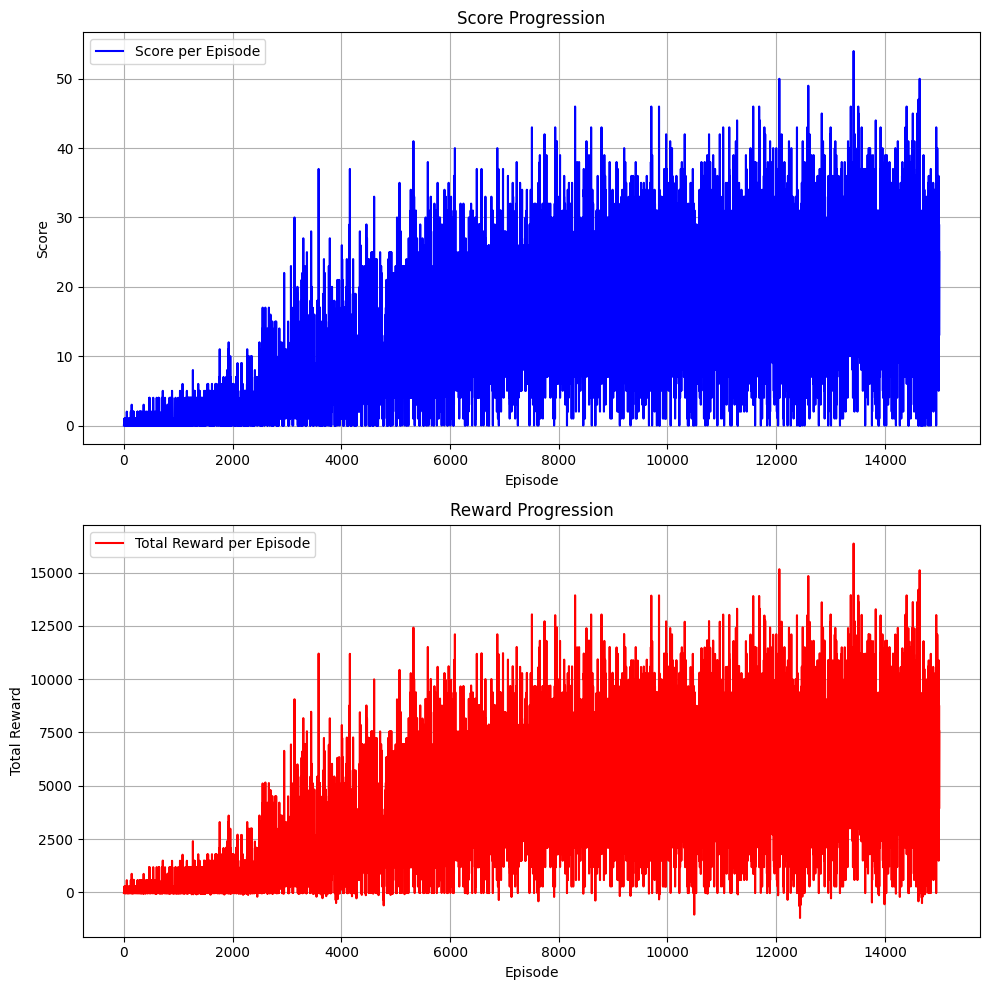

In [39]:
# Plotting Scores and Rewards
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Score Plot
axes[0].plot(scores, label="Score per Episode", color="blue")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Score")
axes[0].set_title("Score Progression")
axes[0].legend()
axes[0].grid()

# Reward Plot
axes[1].plot(total_rewards, label="Total Reward per Episode", color="red")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Total Reward")
axes[1].set_title("Reward Progression")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [40]:
import pandas as pd
import imageio

results_df = pd.DataFrame({
    'Episode': list(range(1, len(scores) + 1)),
    'Score': scores,
    'Total Reward': total_rewards
})

top_games = results_df.sort_values(by=['Score', 'Total Reward'], ascending=False).head(10)
top_games.reset_index(drop=True, inplace=True)

print(top_games)

   Episode  Score  Total Reward
0    13425     54  16366.278125
1    12058     50  15162.325000
2    14640     50  15113.803125
3    12591     49  14842.478125
4    14616     47  14196.678125
5    13373     46  13946.346875
6     8301     46  13937.353125
7    14400     46  13934.765625
8     9845     46  13934.484375
9    13510     46  13926.275000


In [ ]:
def save_snake_game_gif(agent, game, episode_num, filename="snake_game.gif", max_steps=7000):
    frames = []
    state = game.reset()
    done = False
    steps = 0

    agent.epsilon = 0.0  # Disable exploration to ensure consistent behavior

    while not done and steps < max_steps:
        action = agent.act(state)
        next_state, reward, done = game.step(action)
        state = next_state
        steps += 1

        # Capture frame
        surface = pygame.display.get_surface()
        if surface:
            frame = pygame.surfarray.array3d(surface).transpose([1, 0, 2])
            frames.append(frame)

        game.render(delay=0)

    game.close()
    imageio.mimsave(filename, frames, fps=10)
    print(f"Saved new game episode based off of trained agent as {filename}")

In [46]:
new_episode = int(top_games.iloc[0]['Episode'])
save_snake_game_gif(agent, SnakeGame(), episode_num=new_episode, filename=f"game_example.gif")


Saved new game episode based off of trained agent as game_example.gif


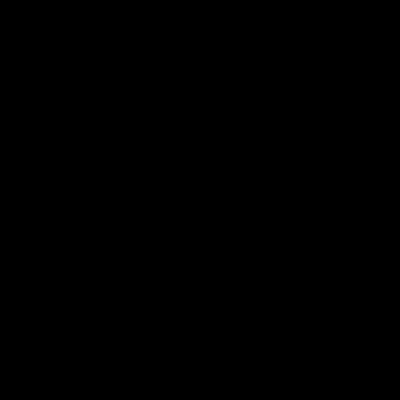

### Results

As training progresses, the agent becomes increasingly proficient at surviving and collecting food. This is reflected in the rising scores and the decrease in epsilon, indicating a shift from exploration to exploitation.

The shaped reward function significantly accelerates learning by giving feedback not only for major events (like eating or dying) but also for intermediate steps (like approaching or avoiding food).

Possible improvements include:

- Experimenting with adding obstacles onto the grid, for the snake to have even more to avoid
- Modifying the states, actions and rewards to prevent trapping itself or running into its own tail when food is behind it.

Overall, we beleive our project successfully demonstrates how reinforcement learning can be applied to learn sequential decision-making in a dynamic environment like Snake.